In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, cohen_kappa_score
from scipy.signal import resample
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

# Load datasets
eeg_data = pd.read_csv('eeg_data_trimmed.csv')
emg_data = pd.read_csv('emg_data_trimmed.csv')
labels = pd.read_csv('labels_trimmed.csv')

# Label encoding
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels.values.ravel())

# Ensure combined_data and labels are aligned
if len(labels) > len(eeg_data):
    labels = labels[:len(eeg_data)]
elif len(labels) < len(eeg_data):
    eeg_data = eeg_data.iloc[:len(labels)]
    emg_data = emg_data.iloc[:len(labels)]

# Resample EEG to match EMG's length (if necessary)
if len(eeg_data) != len(emg_data):
    eeg_data = resample(eeg_data, num=len(emg_data))

# Dynamic Time Warping (DTW) for offline alignment
distance, path = fastdtw(eeg_data.values, emg_data.values, dist=euclidean)
aligned_eeg = eeg_data.iloc[[p[0] for p in path]]
aligned_emg = emg_data.iloc[[p[1] for p in path]]

# Combine aligned data
combined_data = pd.concat([aligned_eeg.reset_index(drop=True), aligned_emg.reset_index(drop=True)], axis=1)

# Ensure combined_data and labels are still aligned
if len(labels) > len(combined_data):
    labels = labels[:len(combined_data)]
elif len(labels) < len(combined_data):
    combined_data = combined_data.iloc[:len(labels)]

class EEGEMGDataset(Dataset):
    def __init__(self, X, y, noise_std=0.01):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        self.noise_std = noise_std

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X_noisy = self.X[idx] + torch.normal(0, self.noise_std, size=self.X[idx].shape)
        return X_noisy, self.y[idx]

# CNN-GRU Model
class CNNGRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, kernel_size=3, num_filters=16, dropout_rate=0.7):
        super(CNNGRUModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        self.gru = nn.GRU(input_size=num_filters, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  
        cnn_out = self.cnn(x).permute(0, 2, 1)  
        gru_out, _ = self.gru(cnn_out)
        output = self.fc(gru_out[:, -1, :])  
        return output

# Train function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=25, patience=5, model_save_path="best_model.pth"):
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
            torch.save(best_model_state, model_save_path)  
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                model.load_state_dict(best_model_state)
                break



# Online Learning Function
def online_adaptation(model, optimizer, buffer_X, buffer_y, criterion, val_loader, num_cycles=3, batch_size=16, lr=0.0001):
    model.train()
    buffer_dataset = EEGEMGDataset(buffer_X, buffer_y)
    buffer_loader = DataLoader(buffer_dataset, batch_size=batch_size, shuffle=True)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.005)

    for cycle in range(num_cycles):
        print(f"Online Adaptation Cycle {cycle + 1}/{num_cycles}")
        for X_batch, y_batch in buffer_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        print("Validation Metrics After Cycle:")
        evaluate_model(model, val_loader)

from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef

# Compute Metrics Function (Updated)
def compute_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    kappa_score = cohen_kappa_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    return precision, recall, f1, accuracy, balanced_acc, kappa_score, mcc

# Evaluation function (Updated)
def evaluate_model(model, val_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    precision, recall, f1, accuracy, balanced_acc, kappa_score, mcc = compute_metrics(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}, Accuracy: {accuracy:.2f}")
    print(f"Balanced Accuracy: {balanced_acc:.2f}, Cohen's Kappa: {kappa_score:.2f}, MCC: {mcc:.2f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    return precision, recall, f1, accuracy, balanced_acc, kappa_score, mcc, conf_matrix
# K-Fold Cross-Validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
fold_results = []
online_adaptation_percentage = 0.3  
# Updated evaluation after training and online adaptation
for fold, (train_index, val_index) in enumerate(kf.split(combined_data)):
    print(f"Fold {fold + 1}/{k}")
    X_train, X_val = combined_data.iloc[train_index].values, combined_data.iloc[val_index].values
    y_train, y_val = labels[train_index], labels[val_index]

    adaptation_size = int(len(X_val) * online_adaptation_percentage)
    buffer_X, buffer_y = X_val[:adaptation_size], y_val[:adaptation_size]
    X_val, y_val = X_val[adaptation_size:], y_val[adaptation_size:]

    train_dataset = EEGEMGDataset(X_train, y_train, noise_std=0.02)
    val_dataset = EEGEMGDataset(X_val, y_val, noise_std=0.0)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    model = CNNGRUModel(input_dim=X_train.shape[1], hidden_dim=128, num_classes=len(np.unique(labels)), num_filters=16, dropout_rate=0.7)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

    train_model(model, train_loader, val_loader, criterion, optimizer)
    
    print("\nInitial Evaluation Before Online Learning:")
    evaluate_model(model, val_loader)
    
    online_adaptation(model, optimizer, buffer_X, buffer_y, criterion, val_loader)
    
    print("\nFinal Evaluation After Online Learning:")
    evaluate_model(model, val_loader)


Fold 1/5
Epoch 1/25, Loss: 1.9453, Val Loss: 1.9357
Epoch 2/25, Loss: 1.8691, Val Loss: 1.8845
Epoch 3/25, Loss: 1.7905, Val Loss: 1.8569
Epoch 4/25, Loss: 1.7018, Val Loss: 1.7259
Epoch 5/25, Loss: 1.5530, Val Loss: 1.5686
Epoch 6/25, Loss: 1.3739, Val Loss: 1.6682
Epoch 7/25, Loss: 1.1980, Val Loss: 1.1058
Epoch 8/25, Loss: 1.0593, Val Loss: 1.0258
Epoch 9/25, Loss: 0.9846, Val Loss: 0.9528
Epoch 10/25, Loss: 1.0117, Val Loss: 0.8832
Epoch 11/25, Loss: 0.8883, Val Loss: 0.9308
Epoch 12/25, Loss: 0.8679, Val Loss: 0.8274
Epoch 13/25, Loss: 0.8135, Val Loss: 0.8387
Epoch 14/25, Loss: 0.7198, Val Loss: 0.7437
Epoch 15/25, Loss: 0.6919, Val Loss: 0.7671
Epoch 16/25, Loss: 0.6631, Val Loss: 0.6767
Epoch 17/25, Loss: 0.6383, Val Loss: 0.6394
Epoch 18/25, Loss: 0.6159, Val Loss: 0.6549
Epoch 19/25, Loss: 0.5817, Val Loss: 0.5846
Epoch 20/25, Loss: 0.5759, Val Loss: 0.5582
Epoch 21/25, Loss: 0.5602, Val Loss: 0.6319
Epoch 22/25, Loss: 0.5722, Val Loss: 0.6090
Epoch 23/25, Loss: 0.5335, Val L

C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.88, Recall: 0.85, F1 Score: 0.86, Accuracy: 0.85
Balanced Accuracy: 0.87, Cohen's Kappa: 0.81, MCC: 0.81
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0   6   0   0   0   0   0]
 [  0   0 117  14   7   0   1]
 [  4   1  19 101   7   1   3]
 [ 10   0  18   1 109   0   1]
 [  0   0   0   8   0 150   0]
 [  0  10   0   2   0   0 114]]
Online Adaptation Cycle 1/3
Validation Metrics After Cycle:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.74, Recall: 0.53, F1 Score: 0.58, Accuracy: 0.53
Balanced Accuracy: 0.59, Cohen's Kappa: 0.45, MCC: 0.49
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0   6   0   0   0   0   0]
 [ 32   2  86  12   4   3   0]
 [ 21  33  24  35   3  17   3]
 [109   3  11   3  13   0   0]
 [  0   0   0   0   0 155   3]
 [  0  44   0   0   6   0  76]]
Online Adaptation Cycle 2/3
Validation Metrics After Cycle:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.72, Recall: 0.48, F1 Score: 0.54, Accuracy: 0.48
Balanced Accuracy: 0.55, Cohen's Kappa: 0.40, MCC: 0.44
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0   6   0   0   0   0   0]
 [ 58   2  60  10   6   3   0]
 [ 25  33  23  37   4  10   4]
 [115   4   7   2  10   0   1]
 [  0   0   0   1   0 152   5]
 [  0  51   0   0   5   0  70]]
Online Adaptation Cycle 3/3
Validation Metrics After Cycle:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.72, Recall: 0.47, F1 Score: 0.54, Accuracy: 0.47
Balanced Accuracy: 0.55, Cohen's Kappa: 0.40, MCC: 0.44
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0   6   0   0   0   0   0]
 [ 63   4  55  12   3   2   0]
 [ 27  32  17  42   3   8   7]
 [114   4   8   2  10   0   1]
 [  0   0   0   1   0 147  10]
 [  0  45   0   0   7   0  74]]

Final Evaluation After Online Learning:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.72, Recall: 0.47, F1 Score: 0.54, Accuracy: 0.47
Balanced Accuracy: 0.55, Cohen's Kappa: 0.40, MCC: 0.44
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0   6   0   0   0   0   0]
 [ 63   4  55  12   3   2   0]
 [ 27  32  17  42   3   8   7]
 [114   4   8   2  10   0   1]
 [  0   0   0   1   0 147  10]
 [  0  45   0   0   7   0  74]]
Fold 2/5
Epoch 1/25, Loss: 1.9412, Val Loss: 1.9268
Epoch 2/25, Loss: 1.8781, Val Loss: 1.8413
Epoch 3/25, Loss: 1.6923, Val Loss: 1.7022
Epoch 4/25, Loss: 1.6433, Val Loss: 1.8500
Epoch 5/25, Loss: 1.6536, Val Loss: 1.5918
Epoch 6/25, Loss: 1.5777, Val Loss: 1.5787
Epoch 7/25, Loss: 1.4525, Val Loss: 1.5735
Epoch 8/25, Loss: 1.3832, Val Loss: 1.3620
Epoch 9/25, Loss: 1.2007, Val Loss: 1.1015
Epoch 10/25, Loss: 1.3616, Val Loss: 1.3762
Epoch 11/25, Loss: 1.0798, Val Loss: 1.0019
Epoch 12/25, Loss: 0.9260, Val Loss: 0.9891
Epoch 13/25, Loss: 0.8388, Val Loss: 0.7954
Epoch 14/25, Loss: 0.7864, Val Loss: 0.7125
Epoch 15/25, Loss: 0.7328, Val

C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.89, Recall: 0.86, F1 Score: 0.87, Accuracy: 0.86
Balanced Accuracy: 0.86, Cohen's Kappa: 0.83, MCC: 0.83
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0 126   6  11   0   0]
 [  1   1  24 101  21   1   0]
 [  0   0   3   2 128   0   0]
 [  0   0   1   4   0 141   0]
 [  0  15   0   6   0   1 111]]
Online Adaptation Cycle 1/3
Validation Metrics After Cycle:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.86, Recall: 0.63, F1 Score: 0.71, Accuracy: 0.63
Balanced Accuracy: 0.63, Cohen's Kappa: 0.57, MCC: 0.60
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [ 12   4 104  10   9   4   0]
 [ 23  25  11  83   3   4   0]
 [106   3   2   1  21   0   0]
 [  0   0   0   4   0 142   0]
 [  0  35   0   2   0   0  96]]
Online Adaptation Cycle 2/3
Validation Metrics After Cycle:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.87, Recall: 0.67, F1 Score: 0.74, Accuracy: 0.67
Balanced Accuracy: 0.66, Cohen's Kappa: 0.61, MCC: 0.63
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  7   6 106  14   4   6   0]
 [ 17  15  10  96   5   6   0]
 [ 97   3   4   1  28   0   0]
 [  0   0   0   4   0 142   0]
 [  0  33   0   1   1   0  98]]
Online Adaptation Cycle 3/3
Validation Metrics After Cycle:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.87, Recall: 0.65, F1 Score: 0.72, Accuracy: 0.65
Balanced Accuracy: 0.65, Cohen's Kappa: 0.59, MCC: 0.61
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  8   5 109  11   3   7   0]
 [ 18  19  14  89   5   4   0]
 [ 98   4   4   1  26   0   0]
 [  0   0   0   7   0 139   0]
 [  0  35   0   1   0   1  96]]

Final Evaluation After Online Learning:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.87, Recall: 0.65, F1 Score: 0.72, Accuracy: 0.65
Balanced Accuracy: 0.65, Cohen's Kappa: 0.59, MCC: 0.61
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  8   5 109  11   3   7   0]
 [ 18  19  14  89   5   4   0]
 [ 98   4   4   1  26   0   0]
 [  0   0   0   7   0 139   0]
 [  0  35   0   1   0   1  96]]
Fold 3/5
Epoch 1/25, Loss: 1.9424, Val Loss: 1.9442
Epoch 2/25, Loss: 1.8596, Val Loss: 1.7995
Epoch 3/25, Loss: 1.7623, Val Loss: 1.7642
Epoch 4/25, Loss: 1.7201, Val Loss: 1.7276
Epoch 5/25, Loss: 1.5355, Val Loss: 1.6117
Epoch 6/25, Loss: 1.3422, Val Loss: 1.3872
Epoch 7/25, Loss: 1.2470, Val Loss: 1.3995
Epoch 8/25, Loss: 1.1788, Val Loss: 1.2226
Epoch 9/25, Loss: 1.0672, Val Loss: 1.2905
Epoch 10/25, Loss: 1.0233, Val Loss: 1.1179
Epoch 11/25, Loss: 0.9405, Val Loss: 1.0004
Epoch 12/25, Loss: 0.8312, Val Loss: 0.8304
Epoch 13/25, Loss: 0.7485, Val Loss: 1.0028
Epoch 14/25, Loss: 0.7104, Val Loss: 0.6884
Epoch 15/25, Loss: 0.6291, Val

C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.86, Recall: 0.81, F1 Score: 0.82, Accuracy: 0.81
Balanced Accuracy: 0.82, Cohen's Kappa: 0.76, MCC: 0.77
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0  91   4  16   0   2]
 [ 16   0  37  91  22   8   0]
 [  6   0   4   0 121   0   0]
 [  0   0   0   7   0 136   0]
 [  0  13   0   0   0   1 129]]
Online Adaptation Cycle 1/3
Validation Metrics After Cycle:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.84, Recall: 0.61, F1 Score: 0.68, Accuracy: 0.61
Balanced Accuracy: 0.63, Cohen's Kappa: 0.55, MCC: 0.57
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  9   0  86   3  15   0   0]
 [ 37  17  37  62   5  16   0]
 [ 66   0   5   0  60   0   0]
 [  0   0   0   6   0 137   0]
 [  0  51   0   0   0   6  86]]
Online Adaptation Cycle 2/3
Validation Metrics After Cycle:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.85, Recall: 0.69, F1 Score: 0.74, Accuracy: 0.69
Balanced Accuracy: 0.71, Cohen's Kappa: 0.63, MCC: 0.64
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  1   0  96   2  13   0   1]
 [ 27   3  45  77   8  14   0]
 [ 33   1  10   0  87   0   0]
 [  0   0   0   7   0 136   0]
 [  0  49   0   2   0   2  90]]
Online Adaptation Cycle 3/3
Validation Metrics After Cycle:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.85, Recall: 0.62, F1 Score: 0.68, Accuracy: 0.62
Balanced Accuracy: 0.64, Cohen's Kappa: 0.55, MCC: 0.58
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  4   0 101   1   6   0   1]
 [ 32  18  43  60   5  16   0]
 [ 64   0  11   0  56   0   0]
 [  0   0   0   7   0 136   0]
 [  0  53   0   0   1   7  82]]

Final Evaluation After Online Learning:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.85, Recall: 0.62, F1 Score: 0.68, Accuracy: 0.62
Balanced Accuracy: 0.64, Cohen's Kappa: 0.55, MCC: 0.58
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  4   0 101   1   6   0   1]
 [ 32  18  43  60   5  16   0]
 [ 64   0  11   0  56   0   0]
 [  0   0   0   7   0 136   0]
 [  0  53   0   0   1   7  82]]
Fold 4/5
Epoch 1/25, Loss: 1.9459, Val Loss: 1.9175
Epoch 2/25, Loss: 1.9050, Val Loss: 1.7918
Epoch 3/25, Loss: 1.8111, Val Loss: 1.9533
Epoch 4/25, Loss: 1.7082, Val Loss: 1.5566
Epoch 5/25, Loss: 1.7406, Val Loss: 1.6330
Epoch 6/25, Loss: 1.4951, Val Loss: 1.6559
Epoch 7/25, Loss: 1.4029, Val Loss: 1.3398
Epoch 8/25, Loss: 1.4699, Val Loss: 1.9482
Epoch 9/25, Loss: 1.5177, Val Loss: 1.4551
Epoch 10/25, Loss: 1.3791, Val Loss: 1.3344
Epoch 11/25, Loss: 1.1550, Val Loss: 1.2661
Epoch 12/25, Loss: 1.0791, Val Loss: 1.0610
Epoch 13/25, Loss: 0.9870, Val Loss: 0.9335
Epoch 14/25, Loss: 0.9190, Val Loss: 1.0187
Epoch 15/25, Loss: 0.8950, Val

C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.85, Recall: 0.74, F1 Score: 0.78, Accuracy: 0.74
Balanced Accuracy: 0.78, Cohen's Kappa: 0.69, MCC: 0.70
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0  14   0   0   0   0   0]
 [  2   0 109  19   6   0   0]
 [ 11   2  10  84   8   2   2]
 [ 73   0  17   1  59   0   2]
 [  0   0   0  13   0 137   1]
 [  0   9   0   3   0   1 119]]
Online Adaptation Cycle 1/3
Validation Metrics After Cycle:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.74, Recall: 0.49, F1 Score: 0.55, Accuracy: 0.49
Balanced Accuracy: 0.57, Cohen's Kappa: 0.43, MCC: 0.47
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0  14   0   0   0   0   0]
 [ 52   3  64   6   8   3   0]
 [ 24  22  21  36   1  13   2]
 [140   2   0   0   8   0   2]
 [  0   0   0   6   0 144   1]
 [  0  48   0   1   1   0  82]]
Online Adaptation Cycle 2/3
Validation Metrics After Cycle:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.72, Recall: 0.49, F1 Score: 0.54, Accuracy: 0.49
Balanced Accuracy: 0.57, Cohen's Kappa: 0.42, MCC: 0.46
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0  14   0   0   0   0   0]
 [ 33   4  63  29   3   4   0]
 [ 22  29   9  34   1  17   7]
 [138   5   1   0   6   0   2]
 [  0   1   0   8   0 139   3]
 [  0  40   0   0   1   0  91]]
Online Adaptation Cycle 3/3
Validation Metrics After Cycle:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.76, Recall: 0.46, F1 Score: 0.51, Accuracy: 0.46
Balanced Accuracy: 0.53, Cohen's Kappa: 0.39, MCC: 0.42
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0  13   0   0   0   0   1]
 [ 14  15  65  36   1   5   0]
 [ 23  53   3  27   0   6   7]
 [121   5   8   0   9   0   9]
 [  0   2   0   6   0 123  20]
 [  0  44   0   0   0   0  88]]

Final Evaluation After Online Learning:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.76, Recall: 0.46, F1 Score: 0.51, Accuracy: 0.46
Balanced Accuracy: 0.53, Cohen's Kappa: 0.39, MCC: 0.42
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0  13   0   0   0   0   1]
 [ 14  15  65  36   1   5   0]
 [ 23  53   3  27   0   6   7]
 [121   5   8   0   9   0   9]
 [  0   2   0   6   0 123  20]
 [  0  44   0   0   0   0  88]]
Fold 5/5
Epoch 1/25, Loss: 1.9438, Val Loss: 1.9440
Epoch 2/25, Loss: 1.8781, Val Loss: 1.8725
Epoch 3/25, Loss: 1.7163, Val Loss: 1.6985
Epoch 4/25, Loss: 1.9645, Val Loss: 1.7692
Epoch 5/25, Loss: 1.7518, Val Loss: 1.7563
Epoch 6/25, Loss: 1.6780, Val Loss: 1.6376
Epoch 7/25, Loss: 1.6407, Val Loss: 1.6821
Epoch 8/25, Loss: 1.5468, Val Loss: 1.4656
Epoch 9/25, Loss: 1.5124, Val Loss: 1.9531
Epoch 10/25, Loss: 1.5711, Val Loss: 1.4149
Epoch 11/25, Loss: 1.4258, Val Loss: 1.3954
Epoch 12/25, Loss: 1.2896, Val Loss: 1.1933
Epoch 13/25, Loss: 1.0454, Val Loss: 1.0317
Epoch 14/25, Loss: 0.9266, Val Loss: 1.0602
Epoch 15/25, Loss: 0.8426, Val

C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.84, Recall: 0.71, F1 Score: 0.76, Accuracy: 0.71
Balanced Accuracy: 0.73, Cohen's Kappa: 0.65, MCC: 0.66
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   2  86  22   9   0   0]
 [ 11   4  12 102  11   4   3]
 [ 82   0  12   6  69   0   1]
 [  0   0   0   5   0 121   1]
 [  0  18   0   2   0   0 121]]
Online Adaptation Cycle 1/3
Validation Metrics After Cycle:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.84, Recall: 0.68, F1 Score: 0.73, Accuracy: 0.68
Balanced Accuracy: 0.70, Cohen's Kappa: 0.62, MCC: 0.63
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0 100  12   7   0   0]
 [ 15   4  34  79   8   6   1]
 [ 85   0  13   5  66   0   1]
 [  0   0   0   6   0 120   1]
 [  0  28   0   2   0   0 111]]
Online Adaptation Cycle 2/3
Validation Metrics After Cycle:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.81, Recall: 0.58, F1 Score: 0.65, Accuracy: 0.58
Balanced Accuracy: 0.61, Cohen's Kappa: 0.52, MCC: 0.54
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  3   2  98  10   6   0   0]
 [ 19  16  38  64   4   5   1]
 [116   1  15   2  36   0   0]
 [  0   0   2  11   0 113   1]
 [  0  40   0   1   1   0  99]]
Online Adaptation Cycle 3/3
Validation Metrics After Cycle:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.81, Recall: 0.56, F1 Score: 0.63, Accuracy: 0.56
Balanced Accuracy: 0.59, Cohen's Kappa: 0.49, MCC: 0.52
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  3   2 108   4   2   0   0]
 [ 19  15  48  59   4   1   1]
 [114   1  16   2  37   0   0]
 [  0   0   3  24   0  99   1]
 [  0  43   0   3   2   0  93]]

Final Evaluation After Online Learning:
Precision: 0.81, Recall: 0.56, F1 Score: 0.63, Accuracy: 0.56
Balanced Accuracy: 0.59, Cohen's Kappa: 0.49, MCC: 0.52
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  3   2 108   4   2   0   0]
 [ 19  15  48  59   4   1   1]
 [114   1  16   2  37   0   0]
 [  0   0   3  24   0  99   1]
 [  0  43   0   3   2   0  93]]


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [1]:
import numpy as np

# Updated CNNGRU metrics
cnn_gru_metrics = [
    [0.88, 0.85, 0.86, 0.85, 0.87, 0.81, 0.81],
    [0.89, 0.86, 0.87, 0.86, 0.86, 0.83, 0.83],
    [0.86, 0.81, 0.82, 0.81, 0.82, 0.76, 0.77],
    [0.85, 0.74, 0.78, 0.74, 0.78, 0.69, 0.70],
    [0.84, 0.71, 0.76, 0.71, 0.73, 0.65, 0.66]
]

# Updated Online metrics
online_metrics = [
    [0.74, 0.53, 0.58, 0.53, 0.59, 0.45, 0.49],
    [0.86, 0.63, 0.71, 0.63, 0.63, 0.57, 0.60],
    [0.84, 0.61, 0.68, 0.61, 0.63, 0.55, 0.57],
    [0.74, 0.49, 0.55, 0.49, 0.57, 0.43, 0.47],
    [0.84, 0.68, 0.73, 0.68, 0.70, 0.62, 0.63]
]

# Calculate averages
cnn_gru_avg = np.mean(cnn_gru_metrics, axis=0)
online_avg = np.mean(online_metrics, axis=0)

# Metric labels
metric_labels = [
    "Precision", "Recall", "F1 Score", "Accuracy", "Balanced Accuracy", "Cohen's Kappa", "MCC"
]

# Display results
def display_results(label, averages):
    print(f"Average metrics for {label}:")
    for metric, avg in zip(metric_labels, averages):
        print(f"{metric}: {avg:.2f}")
    print()

display_results("CNNGRU", cnn_gru_avg)
display_results("Online", online_avg)


Average metrics for CNNGRU:
Precision: 0.86
Recall: 0.79
F1 Score: 0.82
Accuracy: 0.79
Balanced Accuracy: 0.81
Cohen's Kappa: 0.75
MCC: 0.75

Average metrics for Online:
Precision: 0.80
Recall: 0.59
F1 Score: 0.65
Accuracy: 0.59
Balanced Accuracy: 0.62
Cohen's Kappa: 0.52
MCC: 0.55



In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, cohen_kappa_score
from scipy.signal import resample
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

# Load datasets
eeg_data = pd.read_csv('eeg_data_trimmed.csv')
emg_data = pd.read_csv('emg_data_trimmed.csv')
labels = pd.read_csv('labels_trimmed.csv')

# Label encoding
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels.values.ravel())

# Ensure combined_data and labels are aligned
if len(labels) > len(eeg_data):
    labels = labels[:len(eeg_data)]
elif len(labels) < len(eeg_data):
    eeg_data = eeg_data.iloc[:len(labels)]
    emg_data = emg_data.iloc[:len(labels)]

# Resample EEG to match EMG's length (if necessary)
if len(eeg_data) != len(emg_data):
    eeg_data = resample(eeg_data, num=len(emg_data))

# Dynamic Time Warping (DTW) for offline alignment
distance, path = fastdtw(eeg_data.values, emg_data.values, dist=euclidean)
aligned_eeg = eeg_data.iloc[[p[0] for p in path]]
aligned_emg = emg_data.iloc[[p[1] for p in path]]

# Combine aligned data
combined_data = pd.concat([aligned_eeg.reset_index(drop=True), aligned_emg.reset_index(drop=True)], axis=1)

# Ensure combined_data and labels are still aligned
if len(labels) > len(combined_data):
    labels = labels[:len(combined_data)]
elif len(labels) < len(combined_data):
    combined_data = combined_data.iloc[:len(labels)]

class EEGEMGDataset(Dataset):
    def __init__(self, X, y, noise_std=0.002):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        self.noise_std = noise_std

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X_noisy = self.X[idx] + torch.normal(0, self.noise_std, size=self.X[idx].shape)
        return X_noisy, self.y[idx]

# CNN-RNN Model
class CNNRNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_filters=16, dropout_rate=0.7):
        super(CNNRNNModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        self.rnn = nn.RNN(input_size=num_filters, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        cnn_out = self.cnn(x).permute(0, 2, 1)
        rnn_out, _ = self.rnn(cnn_out)
        output = self.fc(rnn_out[:, -1, :])
        return output

# TCN Model
class TCNModel(nn.Module):
    def __init__(self, input_dim, num_classes, num_filters=16, dropout_rate=0.7):
        super(TCNModel, self).__init__()
        self.tcn = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Conv1d(in_channels=num_filters, out_channels=num_filters, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate)
        )
        self.fc = nn.Linear(num_filters, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        tcn_out = self.tcn(x).mean(dim=2)
        output = self.fc(tcn_out)
        return output

# Online Adaptation Function
def online_adaptation(model, optimizer, buffer_X, buffer_y, criterion, val_loader, num_cycles=3, batch_size=16, lr=0.0001):
    model.train()
    buffer_dataset = EEGEMGDataset(buffer_X, buffer_y)
    buffer_loader = DataLoader(buffer_dataset, batch_size=batch_size, shuffle=True)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.005)

    for cycle in range(num_cycles):
        print(f"Online Adaptation Cycle {cycle + 1}/{num_cycles}")
        for X_batch, y_batch in buffer_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        print("Validation Metrics After Cycle:")
        evaluate_model(model, val_loader)

from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef

# Compute Metrics Function (Updated)
def compute_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    kappa_score = cohen_kappa_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    return precision, recall, f1, accuracy, balanced_acc, kappa_score, mcc

# Evaluation function (Updated)
def evaluate_model(model, val_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    precision, recall, f1, accuracy, balanced_acc, kappa_score, mcc = compute_metrics(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}, Accuracy: {accuracy:.2f}")
    print(f"Balanced Accuracy: {balanced_acc:.2f}, Cohen's Kappa: {kappa_score:.2f}, MCC: {mcc:.2f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    return precision, recall, f1, accuracy, balanced_acc, kappa_score, mcc, conf_matrix
# K-Fold Cross-Validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
fold_results = []
online_adaptation_percentage = 0.3  
# Updated evaluation after training and online adaptation
for fold, (train_index, val_index) in enumerate(kf.split(combined_data)):
    print(f"Fold {fold + 1}/{k}")
    X_train, X_val = combined_data.iloc[train_index].values, combined_data.iloc[val_index].values
    y_train, y_val = labels[train_index], labels[val_index]

    adaptation_size = int(len(X_val) * online_adaptation_percentage)
    buffer_X, buffer_y = X_val[:adaptation_size], y_val[:adaptation_size]
    X_val, y_val = X_val[adaptation_size:], y_val[adaptation_size:]

    train_dataset = EEGEMGDataset(X_train, y_train, noise_std=0.02)
    val_dataset = EEGEMGDataset(X_val, y_val, noise_std=0.0)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    model = CNNRNNModel(input_dim=X_train.shape[1], hidden_dim=128, num_classes=len(np.unique(labels)), num_filters=16, dropout_rate=0.7)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

    train_model(model, train_loader, val_loader, criterion, optimizer)
    
    print("\nInitial Evaluation Before Online Learning:")
    evaluate_model(model, val_loader)
    
    online_adaptation(model, optimizer, buffer_X, buffer_y, criterion, val_loader)
    
    print("\nFinal Evaluation After Online Learning:")
    evaluate_model(model, val_loader)


Fold 1/5
Epoch 1/25, Loss: 1.9486, Val Loss: 1.9248
Epoch 2/25, Loss: 1.8905, Val Loss: 1.8171
Epoch 3/25, Loss: 1.8563, Val Loss: 1.8744
Epoch 4/25, Loss: 1.8914, Val Loss: 1.8583
Epoch 5/25, Loss: 1.8051, Val Loss: 1.8711
Epoch 6/25, Loss: 1.7662, Val Loss: 1.7644
Epoch 7/25, Loss: 1.7809, Val Loss: 1.9541
Epoch 8/25, Loss: 1.8530, Val Loss: 1.9221
Epoch 9/25, Loss: 1.8079, Val Loss: 1.8652
Epoch 10/25, Loss: 1.8347, Val Loss: 1.8038
Epoch 11/25, Loss: 1.7551, Val Loss: 1.8270
Early stopping triggered.

Initial Evaluation Before Online Learning:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.32, Recall: 0.21, F1 Score: 0.24, Accuracy: 0.21
Balanced Accuracy: 0.23, Cohen's Kappa: 0.10, MCC: 0.11
Confusion Matrix:
[[ 0  0  0  0  0  0  0]
 [ 0  2  2  2  0  0  0]
 [11 41 63 16  3  4  1]
 [ 8 37 47 23  6  6  9]
 [23 34 24 15  8 23 12]
 [34 28 22 15 11 32 16]
 [20 35 14  8  6 22 21]]
Online Adaptation Cycle 1/3
Validation Metrics After Cycle:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.32, Recall: 0.08, F1 Score: 0.10, Accuracy: 0.08
Balanced Accuracy: 0.12, Cohen's Kappa: 0.04, MCC: 0.05
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  1   2   3   0   0   0   0]
 [ 42  49  38   1   4   4   1]
 [ 55  37  28   3   1   6   6]
 [ 85  35  13   1   0   3   2]
 [135   6   3   0   1   7   6]
 [ 62  41  14   0   2   1   6]]
Online Adaptation Cycle 2/3
Validation Metrics After Cycle:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.24, Recall: 0.04, F1 Score: 0.05, Accuracy: 0.04
Balanced Accuracy: 0.11, Cohen's Kappa: 0.02, MCC: 0.02
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  2   3   1   0   0   0   0]
 [ 62  53  18   1   1   3   1]
 [ 67  44  17   1   0   4   3]
 [ 95  34   6   0   0   3   1]
 [146   6   1   0   1   3   1]
 [ 74  44   4   1   1   0   2]]
Online Adaptation Cycle 3/3
Validation Metrics After Cycle:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.47, Recall: 0.03, F1 Score: 0.04, Accuracy: 0.03
Balanced Accuracy: 0.16, Cohen's Kappa: 0.02, MCC: 0.03
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  1   5   0   0   0   0   0]
 [ 78  47  12   0   1   0   1]
 [ 80  49   2   3   2   0   0]
 [ 92  44   2   1   0   0   0]
 [150   7   0   0   0   1   0]
 [ 67  54   2   1   2   0   0]]

Final Evaluation After Online Learning:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.47, Recall: 0.03, F1 Score: 0.04, Accuracy: 0.03
Balanced Accuracy: 0.16, Cohen's Kappa: 0.02, MCC: 0.03
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  1   5   0   0   0   0   0]
 [ 78  47  12   0   1   0   1]
 [ 80  49   2   3   2   0   0]
 [ 92  44   2   1   0   0   0]
 [150   7   0   0   0   1   0]
 [ 67  54   2   1   2   0   0]]
Fold 2/5
Epoch 1/25, Loss: 1.9466, Val Loss: 1.9121
Epoch 2/25, Loss: 1.8861, Val Loss: 1.8440
Epoch 3/25, Loss: 1.8886, Val Loss: 1.9362
Epoch 4/25, Loss: 2.0135, Val Loss: 1.9197
Epoch 5/25, Loss: 1.8976, Val Loss: 1.8265
Epoch 6/25, Loss: 1.9462, Val Loss: 1.9670
Epoch 7/25, Loss: 2.0056, Val Loss: 1.9182
Epoch 8/25, Loss: 1.9562, Val Loss: 1.9445
Epoch 9/25, Loss: 1.9390, Val Loss: 1.9023
Epoch 10/25, Loss: 1.9242, Val Loss: 1.9289
Early stopping triggered.

Initial Evaluation Before Online Learning:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.31, Recall: 0.12, F1 Score: 0.17, Accuracy: 0.12
Balanced Accuracy: 0.12, Cohen's Kappa: 0.05, MCC: 0.07
Confusion Matrix:
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 7 89 17  8 10 11  1]
 [ 2 95 17 11 12 10  2]
 [ 4 84  8  5 19 13  0]
 [ 5 64 16  8 14 39  0]
 [ 4 86 12  2 11 17  1]]
Online Adaptation Cycle 1/3
Validation Metrics After Cycle:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.06, Recall: 0.04, F1 Score: 0.04, Accuracy: 0.04
Balanced Accuracy: 0.04, Cohen's Kappa: -0.00, MCC: -0.00
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  2 123   0   1   1   0  16]
 [  0 118   2   0   1   0  28]
 [  1  98   0   1   1   0  32]
 [  1 102   1   1   2   0  39]
 [  5  97   1   0   2   0  28]]
Online Adaptation Cycle 2/3
Validation Metrics After Cycle:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.04, Recall: 0.01, F1 Score: 0.01, Accuracy: 0.01
Balanced Accuracy: 0.01, Cohen's Kappa: 0.00, MCC: 0.00
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [ 19 121   0   0   0   0   3]
 [ 14 130   0   0   0   0   5]
 [ 22 109   0   0   0   0   2]
 [ 33 107   0   0   0   0   6]
 [ 23 106   0   0   0   0   4]]
Online Adaptation Cycle 3/3
Validation Metrics After Cycle:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.00, Recall: 0.00, F1 Score: 0.00, Accuracy: 0.00
Balanced Accuracy: 0.00, Cohen's Kappa: 0.00, MCC: 0.00
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [ 23 120   0   0   0   0   0]
 [ 21 128   0   0   0   0   0]
 [ 31 102   0   0   0   0   0]
 [ 44 102   0   0   0   0   0]
 [ 25 108   0   0   0   0   0]]

Final Evaluation After Online Learning:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.00, Recall: 0.00, F1 Score: 0.00, Accuracy: 0.00
Balanced Accuracy: 0.00, Cohen's Kappa: 0.00, MCC: 0.00
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [ 23 120   0   0   0   0   0]
 [ 21 128   0   0   0   0   0]
 [ 31 102   0   0   0   0   0]
 [ 44 102   0   0   0   0   0]
 [ 25 108   0   0   0   0   0]]
Fold 3/5
Epoch 1/25, Loss: 1.9466, Val Loss: 1.9069
Epoch 2/25, Loss: 1.9244, Val Loss: 1.9139
Epoch 3/25, Loss: 1.8281, Val Loss: 1.8719
Epoch 4/25, Loss: 1.7695, Val Loss: 1.7295
Epoch 5/25, Loss: 1.8397, Val Loss: 1.8120
Epoch 6/25, Loss: 1.9280, Val Loss: 1.8685
Epoch 7/25, Loss: 1.7794, Val Loss: 2.0579
Epoch 8/25, Loss: 1.8542, Val Loss: 1.9174
Epoch 9/25, Loss: 1.7978, Val Loss: 1.8287
Early stopping triggered.

Initial Evaluation Before Online Learning:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.46, Recall: 0.20, F1 Score: 0.20, Accuracy: 0.20
Balanced Accuracy: 0.21, Cohen's Kappa: 0.11, MCC: 0.13
Confusion Matrix:
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [17 36 24  2 12 22  0]
 [28 59 25  8 11 40  3]
 [49 20  4  1 10 46  1]
 [33 10  4  0  2 92  2]
 [34 47  4  1 10 40  7]]
Online Adaptation Cycle 1/3
Validation Metrics After Cycle:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.46, Recall: 0.10, F1 Score: 0.13, Accuracy: 0.10
Balanced Accuracy: 0.10, Cohen's Kappa: 0.06, MCC: 0.07
Confusion Matrix:
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [33 49 12  0  2 17  0]
 [58 80 13  3  2 18  0]
 [59 49  5  3  3 11  1]
 [87  4  1  0  1 50  0]
 [34 90  3  1  0 13  2]]
Online Adaptation Cycle 2/3
Validation Metrics After Cycle:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.36, Recall: 0.04, F1 Score: 0.06, Accuracy: 0.04
Balanced Accuracy: 0.04, Cohen's Kappa: 0.02, MCC: 0.03
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [ 43  51   3   1   1  13   1]
 [ 74  79   2   1   3  14   1]
 [ 83  39   3   0   0   5   1]
 [116   3   0   0   1  23   0]
 [ 48  83   0   0   1   8   3]]
Online Adaptation Cycle 3/3
Validation Metrics After Cycle:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.31, Recall: 0.02, F1 Score: 0.04, Accuracy: 0.02
Balanced Accuracy: 0.02, Cohen's Kappa: 0.01, MCC: 0.01
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [ 64  40   2   0   1   6   0]
 [ 97  61   0   0   1  13   2]
 [ 95  29   0   0   0   3   4]
 [135   1   0   0   0   7   0]
 [ 68  65   0   0   0   3   7]]

Final Evaluation After Online Learning:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.31, Recall: 0.02, F1 Score: 0.04, Accuracy: 0.02
Balanced Accuracy: 0.02, Cohen's Kappa: 0.01, MCC: 0.01
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [ 64  40   2   0   1   6   0]
 [ 97  61   0   0   1  13   2]
 [ 95  29   0   0   0   3   4]
 [135   1   0   0   0   7   0]
 [ 68  65   0   0   0   3   7]]
Fold 4/5
Epoch 1/25, Loss: 1.9470, Val Loss: 1.9438
Epoch 2/25, Loss: 1.9041, Val Loss: 1.8822
Epoch 3/25, Loss: 1.8901, Val Loss: 1.8902
Epoch 4/25, Loss: 1.8219, Val Loss: 1.7593
Epoch 5/25, Loss: 1.8048, Val Loss: 1.8138
Epoch 6/25, Loss: 1.8292, Val Loss: 1.7294
Epoch 7/25, Loss: 1.7208, Val Loss: 1.7078
Epoch 8/25, Loss: 1.9258, Val Loss: 1.7205
Epoch 9/25, Loss: 1.7492, Val Loss: 1.7248
Epoch 10/25, Loss: 1.8253, Val Loss: 1.7869
Epoch 11/25, Loss: 1.7586, Val Loss: 1.7948
Epoch 12/25, Loss: 1.7555, Val Loss: 1.7533
Early stopping triggered.

Initial Evaluation Before Online Learning:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.34, Recall: 0.22, F1 Score: 0.24, Accuracy: 0.22
Balanced Accuracy: 0.22, Cohen's Kappa: 0.11, MCC: 0.12
Confusion Matrix:
[[ 0  0  0  0  0  0  0]
 [ 6  3  0  2  1  2  0]
 [14 13 70 15  5 12  7]
 [23  4 42 14  6 18 12]
 [63 19 28 11 10  7 14]
 [16 10 61 25  7 26  6]
 [66 17  6  4  5  0 34]]
Online Adaptation Cycle 1/3
Validation Metrics After Cycle:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.17, Recall: 0.01, F1 Score: 0.01, Accuracy: 0.01
Balanced Accuracy: 0.02, Cohen's Kappa: 0.00, MCC: 0.00
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [ 13   1   0   0   0   0   0]
 [114  19   0   0   0   0   3]
 [101  11   4   2   0   1   0]
 [143   9   0   0   0   0   0]
 [137  10   1   1   0   0   2]
 [124   6   0   0   0   0   2]]
Online Adaptation Cycle 2/3
Validation Metrics After Cycle:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.00, Recall: 0.00, F1 Score: 0.00, Accuracy: 0.00
Balanced Accuracy: 0.00, Cohen's Kappa: -0.00, MCC: -0.00
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [ 14   0   0   0   0   0   0]
 [124  12   0   0   0   0   0]
 [110   9   0   0   0   0   0]
 [145   7   0   0   0   0   0]
 [146   5   0   0   0   0   0]
 [126   6   0   0   0   0   0]]
Online Adaptation Cycle 3/3
Validation Metrics After Cycle:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.00, Recall: 0.00, F1 Score: 0.00, Accuracy: 0.00
Balanced Accuracy: 0.01, Cohen's Kappa: -0.00, MCC: -0.00
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [ 13   1   0   0   0   0   0]
 [100  36   0   0   0   0   0]
 [ 94  25   0   0   0   0   0]
 [134  18   0   0   0   0   0]
 [133  18   0   0   0   0   0]
 [119  13   0   0   0   0   0]]

Final Evaluation After Online Learning:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.00, Recall: 0.00, F1 Score: 0.00, Accuracy: 0.00
Balanced Accuracy: 0.01, Cohen's Kappa: -0.00, MCC: -0.00
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [ 13   1   0   0   0   0   0]
 [100  36   0   0   0   0   0]
 [ 94  25   0   0   0   0   0]
 [134  18   0   0   0   0   0]
 [133  18   0   0   0   0   0]
 [119  13   0   0   0   0   0]]
Fold 5/5
Epoch 1/25, Loss: 1.9445, Val Loss: 1.9207
Epoch 2/25, Loss: 1.9115, Val Loss: 1.9239
Epoch 3/25, Loss: 1.8610, Val Loss: 2.0045
Epoch 4/25, Loss: 1.8305, Val Loss: 1.8493
Epoch 5/25, Loss: 1.8410, Val Loss: 1.8728
Epoch 6/25, Loss: 1.7961, Val Loss: 1.8574
Epoch 7/25, Loss: 1.7706, Val Loss: 1.8476
Epoch 8/25, Loss: 1.8687, Val Loss: 1.8724
Epoch 9/25, Loss: 1.8436, Val Loss: 1.8403
Epoch 10/25, Loss: 1.8661, Val Loss: 1.8797
Epoch 11/25, Loss: 1.8260, Val Loss: 1.8217
Epoch 12/25, Loss: 1.6937, Val Loss: 1.7391
Epoch 13/25, Loss: 1.7606, Val Loss: 1.8096
Epoch 14/25, Loss: 1.7313, Val Loss: 1.7733
Epoch 15/25, Loss: 1.8356, V

C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.04, Recall: 0.20, F1 Score: 0.07, Accuracy: 0.20
Balanced Accuracy: 0.20, Cohen's Kappa: 0.00, MCC: 0.00
Confusion Matrix:
[[  0   0   0   0 119]
 [  0   0   0   0 147]
 [  0   0   0   0 170]
 [  0   0   0   0 127]
 [  0   0   0   0 141]]
Online Adaptation Cycle 1/3
Validation Metrics After Cycle:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.04, Recall: 0.20, F1 Score: 0.07, Accuracy: 0.20
Balanced Accuracy: 0.20, Cohen's Kappa: 0.00, MCC: 0.01
Confusion Matrix:
[[  0   0   0   0   0   0]
 [  0   0   0   0   0 119]
 [  0   0   0   0   0 147]
 [  1   0   0   0   0 169]
 [  0   0   0   0   0 127]
 [  0   0   0   0   0 141]]
Online Adaptation Cycle 2/3
Validation Metrics After Cycle:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.21, Recall: 0.21, F1 Score: 0.12, Accuracy: 0.21
Balanced Accuracy: 0.22, Cohen's Kappa: 0.03, MCC: 0.07
Confusion Matrix:
[[  0   0   0   0   0   0]
 [  1   7   0  14  97   0]
 [  2   2   0   9 134   0]
 [  1   2   0  19 148   0]
 [  1   2   0   3 121   0]
 [  1   1   0   5 134   0]]
Online Adaptation Cycle 3/3
Validation Metrics After Cycle:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Precision: 0.31, Recall: 0.15, F1 Score: 0.13, Accuracy: 0.15
Balanced Accuracy: 0.15, Cohen's Kappa: 0.01, MCC: 0.01
Confusion Matrix:
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [25  0  0  1 43 50  0]
 [43  0  0  4 43 56  1]
 [60  1  0  5 42 62  0]
 [37  0  0  0 34 56  0]
 [45  0  0  3 37 52  4]]

Final Evaluation After Online Learning:
Precision: 0.31, Recall: 0.15, F1 Score: 0.13, Accuracy: 0.15
Balanced Accuracy: 0.15, Cohen's Kappa: 0.01, MCC: 0.01
Confusion Matrix:
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [25  0  0  1 43 50  0]
 [43  0  0  4 43 56  1]
 [60  1  0  5 42 62  0]
 [37  0  0  0 34 56  0]
 [45  0  0  3 37 52  4]]


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [2]:
import numpy as np

# Updated CNNGRU metrics
cnn_gru_metrics = [
    [0.88, 0.85, 0.86, 0.85, 0.87, 0.81, 0.81],
    [0.89, 0.86, 0.87, 0.86, 0.86, 0.83, 0.83],
    [0.86, 0.81, 0.82, 0.81, 0.82, 0.76, 0.77],
    [0.85, 0.74, 0.78, 0.74, 0.78, 0.69, 0.70],
    [0.84, 0.71, 0.76, 0.71, 0.73, 0.65, 0.66]
]

# Updated Online metrics
online_metrics = [
    [0.74, 0.53, 0.58, 0.53, 0.59, 0.45, 0.49],
    [0.86, 0.63, 0.71, 0.63, 0.63, 0.57, 0.60],
    [0.84, 0.61, 0.68, 0.61, 0.63, 0.55, 0.57],
    [0.74, 0.49, 0.55, 0.49, 0.57, 0.43, 0.47],
    [0.84, 0.68, 0.73, 0.68, 0.70, 0.62, 0.63]
]

# Updated CNNRNN metrics
cnn_rnn_metrics = [
    [0.32, 0.21, 0.24, 0.21, 0.23, 0.10, 0.11],
    [0.31, 0.12, 0.17, 0.12, 0.12, 0.05, 0.07],
    [0.46, 0.20, 0.20, 0.20, 0.21, 0.11, 0.13],
    [0.34, 0.22, 0.24, 0.22, 0.22, 0.11, 0.12],
    [0.04, 0.20, 0.07, 0.20, 0.20, 0.00, 0.00]
]

# Updated Online metrics for CNNRNN
online_rnn_metrics = [
    [0.32, 0.08, 0.10, 0.08, 0.12, 0.04, 0.05],
    [0.06, 0.04, 0.04, 0.04, 0.04, -0.00, -0.00],
    [0.46, 0.10, 0.13, 0.10, 0.10, 0.06, 0.07],
    [0.17, 0.01, 0.01, 0.01, 0.02, 0.00, 0.00],
    [0.04, 0.20, 0.07, 0.20, 0.20, 0.00, 0.01]
]

# Calculate averages
cnn_gru_avg = np.mean(cnn_gru_metrics, axis=0)
online_avg = np.mean(online_metrics, axis=0)
cnn_rnn_avg = np.mean(cnn_rnn_metrics, axis=0)
online_rnn_avg = np.mean(online_rnn_metrics, axis=0)

# Metric labels
metric_labels = [
    "Precision", "Recall", "F1 Score", "Accuracy", "Balanced Accuracy", "Cohen's Kappa", "MCC"
]

# Display results
def display_results(label, averages):
    print(f"Average metrics for {label}:")
    for metric, avg in zip(metric_labels, averages):
        print(f"{metric}: {avg:.2f}")
    print()

#display_results("CNNGRU", cnn_gru_avg)
#display_results("Online (CNNGRU)", online_avg)
display_results("CNNRNN", cnn_rnn_avg)
display_results("Online (CNNRNN)", online_rnn_avg)


Average metrics for CNNRNN:
Precision: 0.29
Recall: 0.19
F1 Score: 0.18
Accuracy: 0.19
Balanced Accuracy: 0.20
Cohen's Kappa: 0.07
MCC: 0.09

Average metrics for Online (CNNRNN):
Precision: 0.21
Recall: 0.09
F1 Score: 0.07
Accuracy: 0.09
Balanced Accuracy: 0.10
Cohen's Kappa: 0.02
MCC: 0.03



In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, cohen_kappa_score
from scipy.signal import resample
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

# Load datasets
eeg_data = pd.read_csv('eeg_data_trimmed.csv')
emg_data = pd.read_csv('emg_data_trimmed.csv')
labels = pd.read_csv('labels_trimmed.csv')

# Label encoding
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels.values.ravel())

# Ensure combined_data and labels are aligned
if len(labels) > len(eeg_data):
    labels = labels[:len(eeg_data)]
elif len(labels) < len(eeg_data):
    eeg_data = eeg_data.iloc[:len(labels)]
    emg_data = emg_data.iloc[:len(labels)]

# Resample EEG to match EMG's length (if necessary)
if len(eeg_data) != len(emg_data):
    eeg_data = resample(eeg_data, num=len(emg_data))

# Dynamic Time Warping (DTW) for offline alignment
distance, path = fastdtw(eeg_data.values, emg_data.values, dist=euclidean)
aligned_eeg = eeg_data.iloc[[p[0] for p in path]]
aligned_emg = emg_data.iloc[[p[1] for p in path]]

# Combine aligned data
combined_data = pd.concat([aligned_eeg.reset_index(drop=True), aligned_emg.reset_index(drop=True)], axis=1)

# Ensure combined_data and labels are still aligned
if len(labels) > len(combined_data):
    labels = labels[:len(combined_data)]
elif len(labels) < len(combined_data):
    combined_data = combined_data.iloc[:len(labels)]

class EEGEMGDataset(Dataset):
    def __init__(self, X, y, noise_std=0.002):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        self.noise_std = noise_std

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X_noisy = self.X[idx] + torch.normal(0, self.noise_std, size=self.X[idx].shape)
        return X_noisy, self.y[idx]

# CNN-RNN Model
class CNNRNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_filters=16, dropout_rate=0.7):
        super(CNNRNNModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        self.rnn = nn.RNN(input_size=num_filters, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        cnn_out = self.cnn(x).permute(0, 2, 1)
        rnn_out, _ = self.rnn(cnn_out)
        output = self.fc(rnn_out[:, -1, :])
        return output

# TCN Model
class TCNModel(nn.Module):
    def __init__(self, input_dim, num_classes, num_filters=16, dropout_rate=0.7):
        super(TCNModel, self).__init__()
        self.tcn = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Conv1d(in_channels=num_filters, out_channels=num_filters, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate)
        )
        self.fc = nn.Linear(num_filters, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        tcn_out = self.tcn(x).mean(dim=2)
        output = self.fc(tcn_out)
        return output

# Online Adaptation Function
def online_adaptation(model, optimizer, buffer_X, buffer_y, criterion, val_loader, num_cycles=3, batch_size=16, lr=0.0001):
    model.train()
    buffer_dataset = EEGEMGDataset(buffer_X, buffer_y)
    buffer_loader = DataLoader(buffer_dataset, batch_size=batch_size, shuffle=True)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.005)

    for cycle in range(num_cycles):
        print(f"Online Adaptation Cycle {cycle + 1}/{num_cycles}")
        for X_batch, y_batch in buffer_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        print("Validation Metrics After Cycle:")
        evaluate_model(model, val_loader)

from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef

# Compute Metrics Function (Updated)
def compute_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    kappa_score = cohen_kappa_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    return precision, recall, f1, accuracy, balanced_acc, kappa_score, mcc

# Evaluation function (Updated)
def evaluate_model(model, val_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    precision, recall, f1, accuracy, balanced_acc, kappa_score, mcc = compute_metrics(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}, Accuracy: {accuracy:.2f}")
    print(f"Balanced Accuracy: {balanced_acc:.2f}, Cohen's Kappa: {kappa_score:.2f}, MCC: {mcc:.2f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    return precision, recall, f1, accuracy, balanced_acc, kappa_score, mcc, conf_matrix
# K-Fold Cross-Validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
fold_results = []
online_adaptation_percentage = 0.3  
# Updated evaluation after training and online adaptation
for fold, (train_index, val_index) in enumerate(kf.split(combined_data)):
    print(f"Fold {fold + 1}/{k}")
    X_train, X_val = combined_data.iloc[train_index].values, combined_data.iloc[val_index].values
    y_train, y_val = labels[train_index], labels[val_index]

    adaptation_size = int(len(X_val) * online_adaptation_percentage)
    buffer_X, buffer_y = X_val[:adaptation_size], y_val[:adaptation_size]
    X_val, y_val = X_val[adaptation_size:], y_val[adaptation_size:]

    train_dataset = EEGEMGDataset(X_train, y_train, noise_std=0.02)
    val_dataset = EEGEMGDataset(X_val, y_val, noise_std=0.0)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    model = TCNModel(input_dim=X_train.shape[1], num_classes=len(np.unique(labels)), num_filters=16, dropout_rate=0.7)  # Uncomment for TCN

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

    train_model(model, train_loader, val_loader, criterion, optimizer)
    
    print("\nInitial Evaluation Before Online Learning:")
    evaluate_model(model, val_loader)
    
    online_adaptation(model, optimizer, buffer_X, buffer_y, criterion, val_loader)
    
    print("\nFinal Evaluation After Online Learning:")
    evaluate_model(model, val_loader)


Fold 1/5
Epoch 1/25, Loss: 1.9468, Val Loss: 1.9610
Epoch 2/25, Loss: 1.9450, Val Loss: 1.9588
Epoch 3/25, Loss: 1.9434, Val Loss: 1.9468
Epoch 4/25, Loss: 1.9402, Val Loss: 1.9492
Epoch 5/25, Loss: 1.9353, Val Loss: 1.9320
Epoch 6/25, Loss: 1.9289, Val Loss: 1.9367
Epoch 7/25, Loss: 1.9189, Val Loss: 1.9281
Epoch 8/25, Loss: 1.9059, Val Loss: 1.8961
Epoch 9/25, Loss: 1.8880, Val Loss: 1.8658
Epoch 10/25, Loss: 1.8683, Val Loss: 1.8760
Epoch 11/25, Loss: 1.8485, Val Loss: 1.8436
Epoch 12/25, Loss: 1.8262, Val Loss: 1.7941
Epoch 13/25, Loss: 1.8023, Val Loss: 1.7828
Epoch 14/25, Loss: 1.7797, Val Loss: 1.8238
Epoch 15/25, Loss: 1.7650, Val Loss: 1.7703
Epoch 16/25, Loss: 1.7483, Val Loss: 1.7457
Epoch 17/25, Loss: 1.7325, Val Loss: 1.7205
Epoch 18/25, Loss: 1.7136, Val Loss: 1.7154
Epoch 19/25, Loss: 1.7049, Val Loss: 1.7372
Epoch 20/25, Loss: 1.6880, Val Loss: 1.6711
Epoch 21/25, Loss: 1.6839, Val Loss: 1.6661
Epoch 22/25, Loss: 1.6747, Val Loss: 1.6576
Epoch 23/25, Loss: 1.6628, Val L

C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Validation Metrics After Cycle:
Precision: 0.37, Recall: 0.29, F1 Score: 0.27, Accuracy: 0.29
Balanced Accuracy: 0.39, Cohen's Kappa: 0.19, MCC: 0.21
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0   6   0   0   0   0   0]
 [  0  67  40   0   0  17  15]
 [  1  51   9   6   0  29  40]
 [  0  98  17   4   0   2  18]
 [  0   4  20   0   0 127   7]
 [  4  38   3   0   0  54  27]]
Online Adaptation Cycle 2/3
Validation Metrics After Cycle:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: 

Precision: 0.48, Recall: 0.24, F1 Score: 0.24, Accuracy: 0.24
Balanced Accuracy: 0.35, Cohen's Kappa: 0.15, MCC: 0.19
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0   6   0   0   0   0   0]
 [  0  92  28   0   0  13   6]
 [  1  71   4   2   0  18  40]
 [  1 125   1   0   0   0  12]
 [  0  17  11   0   0 117  13]
 [  4  55   1   0   0  49  17]]
Online Adaptation Cycle 3/3
Validation Metrics After Cycle:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: 

Precision: 0.26, Recall: 0.19, F1 Score: 0.19, Accuracy: 0.19
Balanced Accuracy: 0.26, Cohen's Kappa: 0.12, MCC: 0.17
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  2   4   0   0   0   0   0]
 [  0 121   6   0   0   9   3]
 [  2  95   0   0   0  15  24]
 [  4 130   1   0   0   0   4]
 [  0  25   8   0   0 111  14]
 [  6  58   1   0   0  45  16]]

Final Evaluation After Online Learning:
Precision: 0.26, Recall: 0.19, F1 Score: 0.19, Accuracy: 0.19
Balanced Accuracy: 0.26, Cohen's Kappa: 0.12, MCC: 0.17
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  2   4   0   0   0   0   0]
 [  0 121   6   0   0   9   3]
 [  2  95   0   0   0  15  24]
 [  4 130   1   0   0   0   4]
 [  0  25   8   0   0 111  14]
 [  6  58   1   0   0  45  16]]
Fold 2/5
Epoch 1/25, Loss: 1.9579, Val Loss: 1.9412
Epoch 2/25, Loss: 1.9471, Val Loss: 1.9577
Epoch 3/25, Loss: 1.9443, Val Loss: 1.9661
Epoch 4/25, Loss: 1.9428, Val Loss: 1.9588
Epoch 5/25, Loss: 1.9407, Val Loss: 1.9682
Epoch 6/25, Loss: 1.9385, V

C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Validation Metrics After Cycle:
Precision: 0.00, Recall: 0.00, F1 Score: 0.00, Accuracy: 0.00
Balanced Accuracy: 0.00, Cohen's Kappa: 0.00, MCC: 0.00
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [ 20 123   0   0   0   0   0]
 [ 62  87   0   0   0   0   0]
 [ 46  87   0   0   0   0   0]
 [  8 138   0   0   0   0   0]
 [ 62  71   0   0   0   0   0]]
Online Adaptation Cycle 2/3


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Validation Metrics After Cycle:
Precision: 0.00, Recall: 0.00, F1 Score: 0.00, Accuracy: 0.00
Balanced Accuracy: 0.00, Cohen's Kappa: 0.00, MCC: 0.00
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [ 33 110   0   0   0   0   0]
 [ 79  70   0   0   0   0   0]
 [ 66  67   0   0   0   0   0]
 [ 26 120   0   0   0   0   0]
 [ 78  55   0   0   0   0   0]]
Online Adaptation Cycle 3/3


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Validation Metrics After Cycle:
Precision: 0.00, Recall: 0.00, F1 Score: 0.00, Accuracy: 0.00
Balanced Accuracy: 0.00, Cohen's Kappa: 0.00, MCC: 0.00
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [ 51  92   0   0   0   0   0]
 [101  48   0   0   0   0   0]
 [ 89  44   0   0   0   0   0]
 [ 39 107   0   0   0   0   0]
 [ 91  42   0   0   0   0   0]]

Final Evaluation After Online Learning:
Precision: 0.00, Recall: 0.00, F1 Score: 0.00, Accuracy: 0.00
Balanced Accuracy: 0.00, Cohen's Kappa: 0.00, MCC: 0.00
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [ 51  92   0   0   0   0   0]
 [101  48   0   0   0   0   0]
 [ 89  44   0   0   0   0   0]
 [ 39 107   0   0   0   0   0]
 [ 91  42   0   0   0   0   0]]
Fold 3/5


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: 

Epoch 1/25, Loss: 1.9485, Val Loss: 1.9379
Epoch 2/25, Loss: 1.9437, Val Loss: 1.9519
Epoch 3/25, Loss: 1.9425, Val Loss: 1.9482
Epoch 4/25, Loss: 1.9416, Val Loss: 1.9487
Epoch 5/25, Loss: 1.9400, Val Loss: 1.9417
Epoch 6/25, Loss: 1.9381, Val Loss: 1.9462
Early stopping triggered.

Initial Evaluation Before Online Learning:
Precision: 0.06, Recall: 0.20, F1 Score: 0.08, Accuracy: 0.20
Balanced Accuracy: 0.22, Cohen's Kappa: 0.03, MCC: 0.04
Confusion Matrix:
[[  0   0   0   0   0   0]
 [  0  10   0 103   0   0]
 [ 10   5   0 159   0   0]
 [  1   0   0 130   0   0]
 [  0  87   0  56   0   0]
 [  3  28   0 112   0   0]]
Online Adaptation Cycle 1/3


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Validation Metrics After Cycle:
Precision: 0.00, Recall: 0.00, F1 Score: 0.00, Accuracy: 0.00
Balanced Accuracy: 0.00, Cohen's Kappa: -0.00, MCC: -0.02
Confusion Matrix:
[[  0   0   0   0   0   0]
 [113   0   0   0   0   0]
 [174   0   0   0   0   0]
 [131   0   0   0   0   0]
 [126  17   0   0   0   0]
 [139   4   0   0   0   0]]
Online Adaptation Cycle 2/3
Validation Metrics After Cycle:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: 

Precision: 0.00, Recall: 0.00, F1 Score: 0.00, Accuracy: 0.00
Balanced Accuracy: 0.00, Cohen's Kappa: 0.00, MCC: 0.00
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [113   0   0   0   0   0   0]
 [174   0   0   0   0   0   0]
 [128   3   0   0   0   0   0]
 [143   0   0   0   0   0   0]
 [137   6   0   0   0   0   0]]
Online Adaptation Cycle 3/3
Validation Metrics After Cycle:
Precision: 0.00, Recall: 0.00, F1 Score: 0.00, Accuracy: 0.00
Balanced Accuracy: 0.00, Cohen's Kappa: 0.00, MCC: 0.00
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [103  10   0   0   0   0   0]
 [109  65   0   0   0   0   0]
 [ 87  44   0   0   0   0   0]
 [143   0   0   0   0   0   0]
 [ 88  55   0   0   0   0   0]]

Final Evaluation After Online Learning:
Precision: 0.00, Recall: 0.00, F1 Score: 0.00, Accuracy: 0.00
Balanced Accuracy: 0.00, Cohen's Kappa: 0.00, MCC: 0.00
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   

C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch 1/25, Loss: 1.9532, Val Loss: 1.9776
Epoch 2/25, Loss: 1.9470, Val Loss: 1.9577
Epoch 3/25, Loss: 1.9461, Val Loss: 1.9507
Epoch 4/25, Loss: 1.9457, Val Loss: 1.9487
Epoch 5/25, Loss: 1.9453, Val Loss: 1.9488
Epoch 6/25, Loss: 1.9440, Val Loss: 1.9493
Epoch 7/25, Loss: 1.9432, Val Loss: 1.9500
Epoch 8/25, Loss: 1.9416, Val Loss: 1.9408
Epoch 9/25, Loss: 1.9394, Val Loss: 1.9390
Epoch 10/25, Loss: 1.9358, Val Loss: 1.9303
Epoch 11/25, Loss: 1.9318, Val Loss: 1.9316
Epoch 12/25, Loss: 1.9262, Val Loss: 1.9149
Epoch 13/25, Loss: 1.9179, Val Loss: 1.9230
Epoch 14/25, Loss: 1.9093, Val Loss: 1.9010
Epoch 15/25, Loss: 1.8972, Val Loss: 1.8700
Epoch 16/25, Loss: 1.8822, Val Loss: 1.8499
Epoch 17/25, Loss: 1.8685, Val Loss: 1.8194
Epoch 18/25, Loss: 1.8512, Val Loss: 1.8265
Epoch 19/25, Loss: 1.8341, Val Loss: 1.8128
Epoch 20/25, Loss: 1.8183, Val Loss: 1.8017
Epoch 21/25, Loss: 1.7976, Val Loss: 1.7951
Epoch 22/25, Loss: 1.7827, Val Loss: 1.7412
Epoch 23/25, Loss: 1.7702, Val Loss: 1.72

C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Validation Metrics After Cycle:
Precision: 0.23, Recall: 0.24, F1 Score: 0.17, Accuracy: 0.24
Balanced Accuracy: 0.19, Cohen's Kappa: 0.12, MCC: 0.15
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [ 13   0   0   1   0   0   0]
 [ 60   1   1  26   0  48   0]
 [ 26  23   0  24   0  46   0]
 [ 85  10   0  38   0  19   0]
 [  2   0   1   7   0 141   0]
 [ 13  32   0  22   0  65   0]]
Online Adaptation Cycle 2/3


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Validation Metrics After Cycle:
Precision: 0.30, Recall: 0.22, F1 Score: 0.18, Accuracy: 0.22
Balanced Accuracy: 0.17, Cohen's Kappa: 0.14, MCC: 0.18
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [ 14   0   0   0   0   0   0]
 [ 96   0   2  10   0  28   0]
 [ 49  21   1  15   0  33   0]
 [133   4   0   5   0  10   0]
 [ 11   0   0   3   0 137   0]
 [ 27  38   0  11   0  56   0]]
Online Adaptation Cycle 3/3
Validation Metrics After Cycle:


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: 

Precision: 0.18, Recall: 0.19, F1 Score: 0.16, Accuracy: 0.19
Balanced Accuracy: 0.15, Cohen's Kappa: 0.13, MCC: 0.17
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [ 14   0   0   0   0   0   0]
 [124   0   0   0   0  12   0]
 [ 67  25   0   3   0  24   0]
 [144   2   0   1   0   5   0]
 [ 18   1   0   2   0 130   0]
 [ 34  41   0   3   0  54   0]]

Final Evaluation After Online Learning:
Precision: 0.18, Recall: 0.19, F1 Score: 0.16, Accuracy: 0.19
Balanced Accuracy: 0.15, Cohen's Kappa: 0.13, MCC: 0.17
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [ 14   0   0   0   0   0   0]
 [124   0   0   0   0  12   0]
 [ 67  25   0   3   0  24   0]
 [144   2   0   1   0   5   0]
 [ 18   1   0   2   0 130   0]
 [ 34  41   0   3   0  54   0]]
Fold 5/5
Epoch 1/25, Loss: 1.9556, Val Loss: 1.9594
Epoch 2/25, Loss: 1.9471, Val Loss: 1.9629
Epoch 3/25, Loss: 1.9456, Val Loss: 1.9638
Epoch 4/25, Loss: 1.9449, Val Loss: 1.9597
Epoch 5/25, Loss: 1.9444, Val Loss: 1.9601
Epoch 6/25, Loss: 1.9436, V

C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Validation Metrics After Cycle:
Precision: 0.00, Recall: 0.00, F1 Score: 0.00, Accuracy: 0.00
Balanced Accuracy: 0.00, Cohen's Kappa: 0.00, MCC: 0.00
Confusion Matrix:
[[  0   0   0   0   0   0]
 [119   0   0   0   0   0]
 [147   0   0   0   0   0]
 [170   0   0   0   0   0]
 [127   0   0   0   0   0]
 [141   0   0   0   0   0]]
Online Adaptation Cycle 2/3


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Validation Metrics After Cycle:
Precision: 0.00, Recall: 0.00, F1 Score: 0.00, Accuracy: 0.00
Balanced Accuracy: 0.00, Cohen's Kappa: 0.00, MCC: 0.00
Confusion Matrix:
[[  0   0   0   0   0   0]
 [119   0   0   0   0   0]
 [147   0   0   0   0   0]
 [170   0   0   0   0   0]
 [127   0   0   0   0   0]
 [141   0   0   0   0   0]]
Online Adaptation Cycle 3/3


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: 

Validation Metrics After Cycle:
Precision: 0.00, Recall: 0.00, F1 Score: 0.00, Accuracy: 0.00
Balanced Accuracy: 0.00, Cohen's Kappa: 0.00, MCC: 0.00
Confusion Matrix:
[[  0   0   0   0   0   0]
 [119   0   0   0   0   0]
 [147   0   0   0   0   0]
 [170   0   0   0   0   0]
 [127   0   0   0   0   0]
 [141   0   0   0   0   0]]

Final Evaluation After Online Learning:
Precision: 0.00, Recall: 0.00, F1 Score: 0.00, Accuracy: 0.00
Balanced Accuracy: 0.00, Cohen's Kappa: 0.00, MCC: 0.00
Confusion Matrix:
[[  0   0   0   0   0   0]
 [119   0   0   0   0   0]
 [147   0   0   0   0   0]
 [170   0   0   0   0   0]
 [127   0   0   0   0   0]
 [141   0   0   0   0   0]]


C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tsultan1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [3]:
import numpy as np

# CNNGRU metrics
cnn_gru_metrics = [
    [0.84, 0.78, 0.76, 0.78, 0.82, 0.72, 0.74],
    [0.79, 0.74, 0.70, 0.74, 0.62, 0.67, 0.70],
    [0.57, 0.55, 0.54, 0.55, 0.54, 0.46, 0.49],
    [0.10, 0.20, 0.12, 0.20, 0.21, 0.05, 0.07],
    [0.39, 0.31, 0.29, 0.31, 0.29, 0.17, 0.19]
]

# Online metrics for CNNGRU
online_metrics_cnn_gru = [
    [0.85, 0.81, 0.81, 0.81, 0.85, 0.77, 0.78],
    [0.61, 0.57, 0.55, 0.57, 0.52, 0.49, 0.53],
    [0.58, 0.50, 0.45, 0.50, 0.47, 0.39, 0.42],
    [0.07, 0.04, 0.05, 0.04, 0.04, 0.02, 0.04],
    [0.34, 0.24, 0.25, 0.24, 0.23, 0.11, 0.12]
]

# TCN metrics
tcn_metrics = [
    [0.45, 0.34, 0.30, 0.34, 0.40, 0.21, 0.23],
    [0.01, 0.01, 0.01, 0.01, 0.01, -0.03, -0.04],
    [0.06, 0.20, 0.08, 0.20, 0.22, 0.03, 0.04],
    [0.28, 0.27, 0.18, 0.27, 0.23, 0.13, 0.15],
    [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]
]

# Online metrics for TCN
online_metrics_tcn = [
    [0.37, 0.29, 0.27, 0.29, 0.39, 0.19, 0.21],
    [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
    [0.00, 0.00, 0.00, 0.00, 0.00, -0.00, -0.02],
    [0.23, 0.24, 0.17, 0.24, 0.19, 0.12, 0.15],
    [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]
]

# Calculate averages
cnn_gru_avg = np.mean(cnn_gru_metrics, axis=0)
online_avg_cnn_gru = np.mean(online_metrics_cnn_gru, axis=0)
tcn_avg = np.mean(tcn_metrics, axis=0)
online_avg_tcn = np.mean(online_metrics_tcn, axis=0)

# Metric labels
metric_labels = [
    "Precision", "Recall", "F1 Score", "Accuracy", "Balanced Accuracy", "Cohen's Kappa", "MCC"
]

# Display results
def display_results(label, averages):
    print(f"Average metrics for {label}:")
    for metric, avg in zip(metric_labels, averages):
        print(f"{metric}: {avg:.2f}")
    print()

#display_results("CNNGRU", cnn_gru_avg)
#display_results("Online CNNGRU", online_avg_cnn_gru)
display_results("TCN", tcn_avg)
display_results("Online TCN", online_avg_tcn)


Average metrics for TCN:
Precision: 0.16
Recall: 0.16
F1 Score: 0.11
Accuracy: 0.16
Balanced Accuracy: 0.17
Cohen's Kappa: 0.07
MCC: 0.08

Average metrics for Online TCN:
Precision: 0.12
Recall: 0.11
F1 Score: 0.09
Accuracy: 0.11
Balanced Accuracy: 0.12
Cohen's Kappa: 0.06
MCC: 0.07




Fold 1/5
LDA - Accuracy: 0.8090, Precision: 0.8127, Recall: 0.8090, F1: 0.8089, Kappa: 0.7771, Balanced Accuracy: 0.8089, MCC: 0.7777



Fold 2/5
LDA - Accuracy: 0.7960, Precision: 0.8010, Recall: 0.7960, F1: 0.7961, Kappa: 0.7620, Balanced Accuracy: 0.7964, MCC: 0.7629



Fold 3/5
LDA - Accuracy: 0.7602, Precision: 0.7674, Recall: 0.7602, F1: 0.7613, Kappa: 0.7203, Balanced Accuracy: 0.7607, MCC: 0.7211



Fold 4/5
LDA - Accuracy: 0.8090, Precision: 0.8105, Recall: 0.8090, F1: 0.8091, Kappa: 0.7771, Balanced Accuracy: 0.8092, MCC: 0.7773


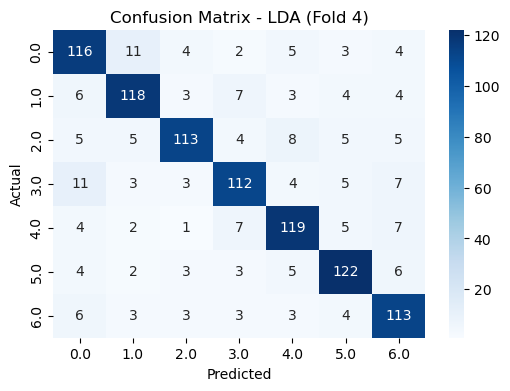


Fold 5/5
LDA - Accuracy: 0.8229, Precision: 0.8274, Recall: 0.8229, F1: 0.8234, Kappa: 0.7934, Balanced Accuracy: 0.8235, MCC: 0.7940


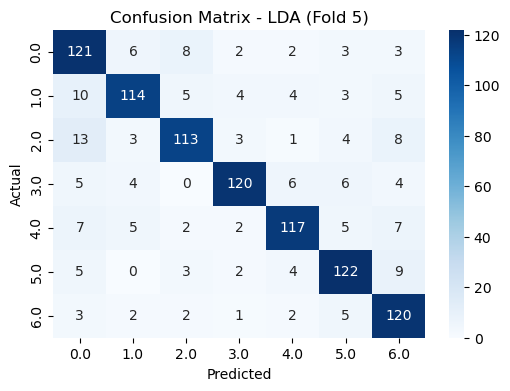


Average Metrics Across Folds:

Model: LDA
Precision: 0.8038
Recall: 0.7994
F1: 0.7997
Accuracy: 0.7994
Kappa: 0.7660
Balanced_accuracy: 0.7997
Mcc: 0.7666


In [5]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (precision_score, recall_score, f1_score, accuracy_score, 
                             confusion_matrix, cohen_kappa_score, balanced_accuracy_score, matthews_corrcoef)
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.signal import resample
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt

# Load datasets
eeg_data = pd.read_csv('eeg_data_trimmed.csv')
emg_data = pd.read_csv('emg_data_trimmed.csv')
labels = pd.read_csv('labels_trimmed.csv')

# Label encoding
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels.values.ravel())

# Check for class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Models to evaluate
models = {
    "LDA": LinearDiscriminantAnalysis()

}

# Stratified k-Fold Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_results = {model_name: [] for model_name in models.keys()}

for fold, (train_index, test_index) in enumerate(kf.split(eeg_data, labels)):
    print(f"\nFold {fold + 1}/5")
    eeg_train, eeg_test = eeg_data.iloc[train_index].values, eeg_data.iloc[test_index].values
    emg_train, emg_test = emg_data.iloc[train_index].values, emg_data.iloc[test_index].values
    y_train, y_test = labels[train_index], labels[test_index]

    # Resample EEG and EMG
    eeg_train = resample(eeg_train, num=len(emg_train), axis=0)
    eeg_test = resample(eeg_test, num=len(emg_test), axis=0)

    # Align using DTW
    def align_signals(signal1, signal2):
        distance, path = fastdtw(signal1, signal2, dist=euclidean)
        aligned_signal1 = signal1[[p[0] for p in path]]
        aligned_signal2 = signal2[[p[1] for p in path]]
        return aligned_signal1, aligned_signal2
    
    aligned_eeg_train, aligned_emg_train = align_signals(eeg_train, emg_train)
    aligned_eeg_test, aligned_emg_test = align_signals(eeg_test, emg_test)

    # Combine and scale
    X_train = np.hstack((aligned_eeg_train, aligned_emg_train))
    X_test = np.hstack((aligned_eeg_test, aligned_emg_test))
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train and evaluate each model
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        accuracy = accuracy_score(y_test, y_pred)
        kappa = cohen_kappa_score(y_test, y_pred)
        balanced_acc = balanced_accuracy_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)

        # Store results
        fold_results[model_name].append({
            "precision": precision, "recall": recall, "f1": f1,
            "accuracy": accuracy, "kappa": kappa,
            "balanced_accuracy": balanced_acc, "mcc": mcc
        })

        # Print per-fold results
        print(f"{model_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, "
              f"F1: {f1:.4f}, Kappa: {kappa:.4f}, Balanced Accuracy: {balanced_acc:.4f}, MCC: {mcc:.4f}")

        # Confusion matrix visualization
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix - {model_name} (Fold {fold+1})")
        plt.show()

# Average metrics across folds
print("\nAverage Metrics Across Folds:")
for model_name, results in fold_results.items():
    avg_metrics = {metric: np.mean([res[metric] for res in results]) for metric in results[0]}
    print(f"\nModel: {model_name}")
    for metric, value in avg_metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")
